In [1]:
import os
import time
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
# wrapper so that model predicts using dask
from dask_ml.wrappers import ParallelPostFit  

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from joblib import dump

import model_prep_and_evals as mpe 

In [2]:
# **************************************************************
# whole_set = True => merge train+test sets and train model with combined dataset
# whole_set = False => train model only with train set

whole_set = False

#root = os.path.join(os.getcwd(), 'processing_results', 'glcm_model_2020')
root = os.getcwd()
train_name = 'modelAE5_FP_train.csv'
test_name = 'modelAE5_FP_test.csv'

# root = os.getcwd()
# train_name = 'glcm_spectral_window_model3070FP_train_2020.csv'
# test_name = 'glcm_spectral_window_model3070FP_test_2020.csv'

first_feature = 'r'
last_feature = 'nir_avg5'
label_name = 'iceplant'

# drops this feature
filter_year = False
year = 2020

save_model = True
model_name = 'modelAE5_FP_2020_rfc'

calculate_feature_importance = True

In [3]:
# cols = ['r','r_avg', 'r_entr5', 'r_contN', 'r_contE', 'r_corrN', #'r_corrN', 
#         'g','g_avg', 'g_entr5', #'g_contN',  'g_corrN', #'g_corrN',
#         'b','b_avg', 'b_entr5', 'b_contN', 'b_contE', 'b_corrN', #'b_corrN',
#         'nir', 'nir_avg', 'nir_entr5', 'nir_contN', 'nir_contE','nir_corrN',# 'nir_corrN',
#          'year', 'month', 'day_in_year' # date
#              ]

# cols = ['r', 'r_avg5', 'r_entr5', 'r_contN', 'r_corrN', 
#         'g', 'g_avg5', 'g_entr5',
#         'b', 'b_avg5', 'b_entr5', 'b_contN', 'b_corrN', 
#         'nir', 'nir_avg5', 'nir_entr5', 'nir_contN', 'nir_corrN', 
#         'month', 'day_in_year']

cols = ['r', 'r_avg5', 'r_entr5', 
'g', 'g_avg5', 'g_entr5', 
'b', 'b_avg5', 'b_entr5',
 'nir', 'nir_avg5', 'nir_entr5',
'month', 'day_in_year']



In [4]:
# ------------------------------
# IMPORT TRAIN DATA
X_train = pd.read_csv(os.path.join(root, train_name)).loc[:, first_feature:last_feature]
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,label_name] 

# ------------------------------
# IMPORT TEST DATA
X_test = pd.read_csv(os.path.join(root, test_name)).loc[:, first_feature:last_feature]
y_test = pd.read_csv(os.path.join(root, test_name)).loc[:,label_name] 



X_test = X_test[cols]
X_train = X_train[cols] 


# ------------------------------
if filter_year:
    
    X_train = X_train.loc[X_train.year == year]
    X_train = X_train.drop(['year'], axis =1)
    y_train = y_train.iloc[X_train.index]

    
    X_test = X_test.loc[X_test.year == year]
    X_test = X_test.drop(['year'], axis =1)
    y_test = y_test.iloc[X_test.index]
    
# ------------------------------
if whole_set == True:
    X_train = pd.concat([X_train, X_test], axis = 0)
    y_train = pd.concat([y_train, y_test], axis = 0)


X_test.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [5]:
X_train.columns

Index(['r', 'r_avg5', 'r_entr5', 'g', 'g_avg5', 'g_entr5', 'b', 'b_avg5',
       'b_entr5', 'nir', 'nir_avg5', 'nir_entr5', 'month', 'day_in_year'],
      dtype='object')

In [6]:
mpe.test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     2.4 :1
          counts  percentage
iceplant                    
0.0         1307       70.99
1.0          534       29.01

TEST SET COUNTS:
no-iceplant:iceplant ratio     2.4 :1
          counts  percentage
iceplant                    
0.0          558       70.81
1.0          230       29.19



In [7]:
# ------------------------------
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [8]:
t0 = time.time()
rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)
print(time.time() - t0)

if save_model:
    dump(rfc, model_name +'.joblib')

0.39757704734802246


In [9]:
if whole_set == False:
    preds = rfc.predict(X_test.to_numpy())
    mpe.print_accuracy_info(y_test.to_numpy(), preds)

true negatives: 539     false positives: 19
false negatives: 78     true positives: 152

sensitivity (TP/P): 66.09 %
specificity (TN/N): 96.59 %
G-mean:  0.8

precision (TP/(TP+FP)): 88.89 %

MCC:  0.6913258558196261

F1-measure:  0.7581
F0.5-measure (min false positives):  0.83151
F2-measure (min false negatives)  :  0.69661

accuracy: 87.69 %


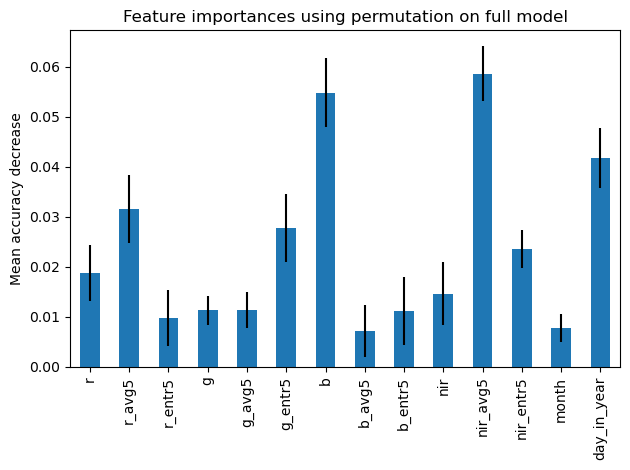

In [10]:
result = permutation_importance(
    rfc, 
    X_test.to_numpy(),
    y_test.to_numpy(),
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()